In [1]:
#importing libraries and packages
import sys,os,time
from io import StringIO
print(sys.executable)
import pandas as pd
from datetime import datetime
import numpy as np
#import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.markers
from pandas.tseries.frequencies import to_offset# needed to set the time offset to match to the muons DF
import seaborn as sns
from numpy import argmax
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder

/usr/bin/python3


In [12]:
"""
Example script that scrapes data from the IEM ASOS download service
"""
from __future__ import print_function
import json
import time
from datetime import datetime, timedelta
#import datetime
import pandas as pd

# Python 2 and 3: alternative 4
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen

# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"


def download_data(uri):
    """Fetch the data from the IEM
    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.
    Args:
      uri (string): URL to fetch
    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print("download_data(%s) failed with %s" % (uri, exp))
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""


def get_stations_from_filelist():
    """Build a listing of stations from a simple file listing the stations.
    The file should simply have one station per line.
    """
    stations = []
    for line in open(filename):
        stations.append(line.strip())
    return stations


def get_stations_from_networks():
    """Build a station list by using a bunch of IEM networks."""
    stations = ["ATL"]
    states = "GA"
    # IEM quirk to have Iowa AWOS sites in its own labeled network
    networks = ["AWOS"]
    for state in states.split():
        networks.append("%s_ASOS" % (state,))

    for network in networks:
        # Get metadata
        uri = (
            "https://mesonet.agron.iastate.edu/" "geojson/network/%s.geojson"
        ) % (network,)
        data = urlopen(uri)
        jdict = json.load(data)
        for site in jdict["features"]:
            stations.append(site["properties"]["sid"])
    return stations

def get_weather_data(start_date, end_date):#this function not called here just for reference 
    """Our main method"""
    # timestamps in UTC to request data for
    startts = start_date
    endts = end_date

    service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&"

    service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
    service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

    # Two examples of how to specify a list of stations
    #stations = get_stations_from_networks()
    #stations = get_stations_from_filelist("stations.txt")
    
    
    #station name and parameter can be found from following the website
    #https://mesonet.agron.iastate.edu/request/download.phtml
    stations = ["VCBI","SKSM","ATL"]  
    data_types = ["tmpf","alti"] #mslp: pressure , tmpf: temperature in F , alti: altitude in inches
    for station in stations:
        
        for station in stations:
            for data_type in data_types:
                service = SERVICE + "data=" + data_type + "&tz=Etc/UTC&format=onlytdf&=yes&"
                service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
                service += endts.strftime("year2=%Y&month2=%m&day2=%d&")
                uri = "%s&station=%s" % (service, station)
                print("Downloading: %s" % (station,))
                data = download_data(uri)
                outfn = "%s_%s.csv" % (
                    station,
                    data_type
                )
                out = open(outfn, "w")
                out.write(data)
                out.close()
                df = pd.read_csv(outfn, sep='\t')
                print(df)
def main():
    
    """Our main method"""
    # timestamps in UTC to request data for
    startts = datetime.utcnow().date() - timedelta(days=1095)#datetime.datetime(2020, 6, 15)
    endts   = datetime.utcnow().date()
    
    
    # Two examples of how to specify a list of stations
    #stations = get_stations_from_networks()
    # stations = get_stations_from_filelist("mystations.txt")
    
    stations = ["SKSM"]
    dfs = []   
    data_types = ["alti", "tmpf"]
    for station in stations:
        
        for data_type in data_types:
     
            service = SERVICE + "data="+data_type+"&tz=Etc/UTC&format=onlytdf&=yes&"

            service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
            service += endts.strftime("year2=%Y&month2=%m&day2=%d&")
    

            
            uri = "%s&station=%s" % (service, station)
            print("Downloading: %s" % (station,))
            data = download_data(uri)
            outfn = "%s_%s_%s.txt" % (
                station,
                startts.strftime("%Y%m%d%H%M"),
                endts.strftime("%Y%m%d%H%M"),
            )
            out = open(outfn, "w")
            out.write(data)
            out.close()
            
            df = pd.read_csv(outfn, sep= '\t' )


            out.close()
            dfs.append(df)




            df.head()
            print(df)
            


    
    final_dataframe = pd.merge(dfs[0], dfs[1])
    print(final_dataframe)
    
    final_dataframe.to_csv("SantaMarta_alti_temp.csv",index = False)




if __name__ == "__main__":
    main()

Downloading: SKSM
      station             valid   alti
0        SKSM  2021-04-26 00:00  29.77
1        SKSM  2021-04-26 01:00  29.77
2        SKSM  2021-04-26 02:00  29.80
3        SKSM  2021-04-26 03:00  29.80
4        SKSM  2021-04-26 11:00  29.80
...       ...               ...    ...
18254    SKSM  2024-04-24 19:00  29.80
18255    SKSM  2024-04-24 20:00  29.77
18256    SKSM  2024-04-24 21:00  29.77
18257    SKSM  2024-04-24 22:00  29.74
18258    SKSM  2024-04-24 23:00  29.74

[18259 rows x 3 columns]
Downloading: SKSM
      station             valid   tmpf
0        SKSM  2021-04-26 00:00  86.00
1        SKSM  2021-04-26 01:00  84.20
2        SKSM  2021-04-26 02:00  84.20
3        SKSM  2021-04-26 03:00  84.20
4        SKSM  2021-04-26 11:00  77.00
...       ...               ...    ...
18254    SKSM  2024-04-24 19:00  95.00
18255    SKSM  2024-04-24 20:00  95.00
18256    SKSM  2024-04-24 21:00  95.00
18257    SKSM  2024-04-24 22:00  93.20
18258    SKSM  2024-04-24 23:00  89.60

[

After split, merged_df1 structure:
      0    1     2                         3
0  154,  70,  125,  Sun Feb 25 05:31:23 2024
1  130,  48,  112,  Sun Feb 25 05:32:23 2024
2  134,  65,  119,  Sun Feb 25 05:33:23 2024
3  159,  60,  125,  Sun Feb 25 05:34:23 2024
4  136,  54,  113,  Sun Feb 25 05:35:23 2024
named_df structure before processing:
  junk1 junk2 counts                date
0  154,   70,   125, 2024-02-25 05:31:23
1  130,   48,   112, 2024-02-25 05:32:23
2  134,   65,   119, 2024-02-25 05:33:23
3  159,   60,   125, 2024-02-25 05:34:23
4  136,   54,   113, 2024-02-25 05:35:23
named_df structure before resampling:
                     counts
date                       
2024-02-25 05:31:23     125
2024-02-25 05:32:23     112
2024-02-25 05:33:23     119
2024-02-25 05:34:23     125
2024-02-25 05:35:23     113
df_hourly structure after resampling:
                     counts
date                       
2023-08-14 14:00:00    1300
2023-08-14 15:00:00       0
2023-08-14 16:00:00       0

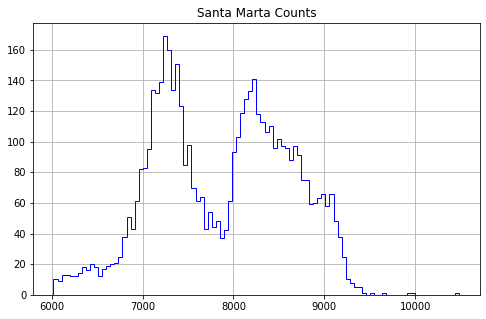

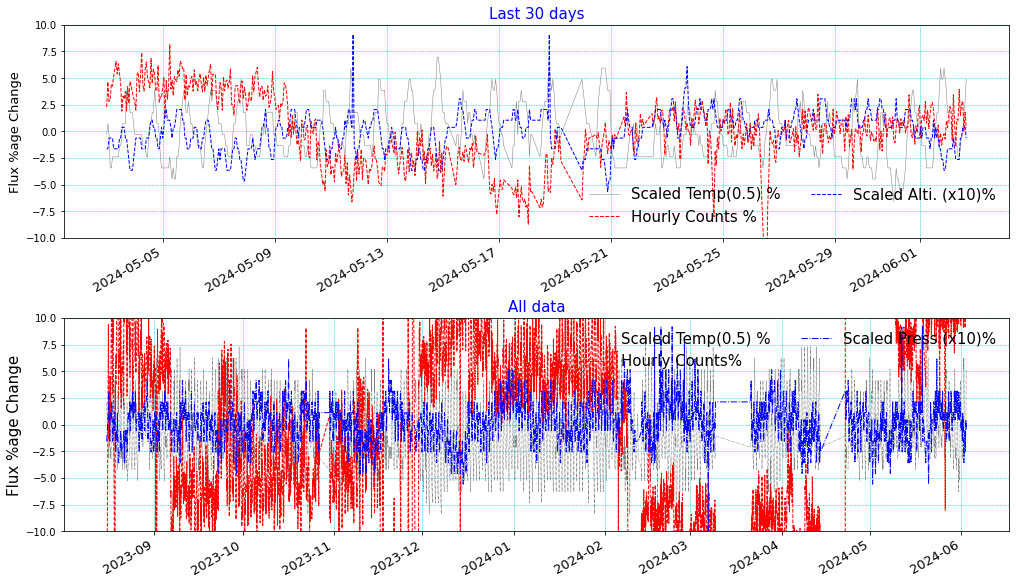

In [9]:

def merge_tables(df1, dfpt):
    df1.index = pd.to_datetime(df1.index)
    dfpt.index = pd.to_datetime(dfpt.index)
    df1.sort_index(inplace=True)
    dfpt.sort_index(inplace=True)
    merged_tab = pd.merge(df1, dfpt, how='inner', left_index=True, right_index=True)
    return merged_tab

def calc_percent_change(merged_df):
    merged_df["counts_pct"] = ((merged_df['counts'] - merged_df['counts'].mean()) / 
                               merged_df['counts'].mean() * 100)
    merged_df["counts_m_avg"] = merged_df.rolling('6H').counts_pct.mean()
    merged_df["press_pct"] = 10 * ((merged_df['alti'] - merged_df['alti'].mean()) / 
                                   merged_df['alti'].mean() * 100)
    merged_df["temp_pct"] = ((merged_df['tmpf'] - merged_df['tmpf'].mean()) / 
                             merged_df['tmpf'].mean() * 100)
    merged_df['temp_scaled'] = 0.5 * merged_df['temp_pct']
    merged_df["delta_cts"] = np.log(merged_df["counts"] / merged_df["counts"].mean())
    merged_df["delta_pres"] = merged_df["alti"] - merged_df["alti"].mean()
    return merged_df

log_directory = '/home/cosmic/SantaMarta/'
all_files = os.listdir(log_directory)
log_files = [file for file in all_files if file.endswith('.log')]

merged_df1 = pd.DataFrame()
for log_file in log_files:
    log_file_path = os.path.join(log_directory, log_file)
    with open(log_file_path, 'r') as file:
        df = pd.read_csv(log_file_path, sep='\t', names=["counts"])
        merged_df1 = pd.concat([merged_df1, df], axis=0, ignore_index=True)

merged_df1 = merged_df1['counts'].str.split(" ", n=3, expand=True)
print("After split, merged_df1 structure:")
print(merged_df1.head())

merged_df1[3] = pd.to_datetime(merged_df1[3], errors='coerce')

if merged_df1[3].isna().any():
    date_range = pd.date_range(start=merged_df1[3].min(), end=merged_df1[3].max(), freq='1T')
    continuous_datetime_df = pd.DataFrame({3: date_range})
    merged_df1 = pd.merge(continuous_datetime_df, merged_df1, on=3, how='left')
    merged_df1 = merged_df1.reindex(columns=merged_df1.columns, fill_value=pd.NaT)

named_df = pd.DataFrame(merged_df1.values, columns=["junk1", "junk2", "counts", "date"])
print("named_df structure before processing:")
print(named_df.head())

named_df['counts'] = named_df['counts'].replace(',', '', regex=True)
named_df["date"] = pd.to_datetime(named_df['date'], format="%a %b %d %H:%M:%S %Y")
named_df = named_df.set_index('date')
named_df["counts"] = named_df["counts"].apply(pd.to_numeric)
named_df.drop(named_df.columns[[0, 1]], axis=1, inplace=True)

# Check the structure of named_df before resampling
print("named_df structure before resampling:")
print(named_df.head())

df_hourly = named_df.resample('H').sum()

# Check the structure of df_hourly after resampling
print("df_hourly structure after resampling:")
print(df_hourly.head())

df_hourly.drop(df_hourly.head(1).index, inplace=True)
df_hourly.drop(df_hourly.tail(1).index, inplace=True)
df_hourly.drop(df_hourly[df_hourly['counts'] < 6000].index, inplace=True)
df_hourly.drop(df_hourly[df_hourly['counts'] > 13000].index, inplace=True)

fPT1 = 'SantaMarta_alti_temp.csv'
df1_PT = pd.read_csv(fPT1)
df1_PT.drop(df1_PT[df1_PT['alti'] == 'M'].index, inplace=True)
df1_PT.drop(df1_PT[df1_PT['tmpf'] == 'M'].index, inplace=True)
df1_PT.dropna(inplace=True)
df1_PT['valid'] = pd.to_datetime(df1_PT['valid'])
df1_PT = df1_PT.set_index('valid')
df1_PT = df1_PT.drop(columns=["station"])
loffset = '-0min'
df1_PT.index = df1_PT.index + to_offset(loffset)
df1_PT["alti"] = df1_PT["alti"].astype(float)
df1_PT["tmpf"] = df1_PT["tmpf"].astype(float)

merged_df1 = merge_tables(df1_PT, df_hourly)

plt.rcParams["axes.grid"] = True
fig, (ax1) = plt.subplots(1, figsize=(8, 5))
ax1.hist(merged_df1['counts'], bins=100, histtype='step', label='Counts', color='blue')
ax1.set_title('Santa Marta Counts')

now = datetime.utcnow().date()
yesterday = now - timedelta(days=1)
lastmonth = now - timedelta(days=31)

merged_df_1day = merged_df1.loc[yesterday:now].copy()
merged_df_31days = merged_df1.loc[lastmonth:now].copy()

merged_df = calc_percent_change(merged_df1)
calc_percent_change(merged_df_1day)
calc_percent_change(merged_df_31days)

fig = plt.figure(figsize=(14, 8), constrained_layout=True)
gs = fig.add_gridspec(2)
axs = gs.subplots(sharex=False, sharey=False)

axs[0].set_title("Last 30 days", fontsize=15, color='blue')
axs[0].plot(merged_df_31days['temp_scaled'], linestyle='-', linewidth=0.5, color='gray', label='Scaled Temp(0.5) %')
axs[0].plot(merged_df_31days['counts_pct'], linestyle='--', linewidth=1, color='red', label='Hourly Counts %')
axs[0].plot(merged_df_31days['press_pct'], linestyle='--', linewidth=1, color='blue', label='Scaled Alti. (x10)%')

axs[1].set_title("All data", fontsize=15, color='blue')
axs[1].plot(merged_df['temp_scaled'], linestyle='-.', linewidth=0.5, color='gray', label='Scaled Temp(0.5) %')
axs[1].plot(merged_df["counts_pct"], linestyle='--', linewidth=1, color='red', label='Hourly Counts%')
axs[1].plot(merged_df["press_pct"], linestyle='-.', linewidth=1, color='blue', label='Scaled Press (x10)%')

axs[0].set_ylabel('Flux %age Change', fontsize=13)
axs[0].set_ylim(-10, 10)
axs[0].legend(ncol=2, frameon=False, fontsize=15)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].grid(True, color='DarkTurquoise', alpha=1, linestyle='--', linewidth=0.5)

axs[1].set_ylabel('Flux %age Change', fontsize=15)
axs[1].set_ylim(-10, 10)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].legend(ncol=2, frameon=False, fontsize=15)
axs[1].grid(True, color='DarkTurquoise', alpha=1, linestyle='--', linewidth=0.5)

plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig('/home/cosmic/onlineMon/images/SantaMarta_pct_Ch_mostrecent.png')


-0.09381564954255871 -0.0007626462385286494 -0.14167073553973983 0.0015266585021757083 0.02943416345201117


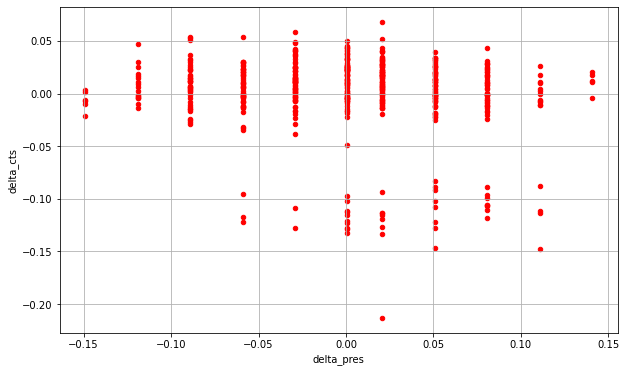

In [21]:
from scipy import stats
#fig, ax = plt.subplots(figsize=(15,10))
slope, intercept, r_value, pv, se = stats.linregress(merged_df_31days['delta_pres'], merged_df_31days['delta_cts'])
print(slope, intercept, r_value, pv, se)
plot_P_T = merged_df_31days.plot.scatter(x='delta_pres',
                   y='delta_cts',
                   c='Red',figsize=(10,6))
baro_coeff = slope;

In [22]:
# pressure correction
merged_df1["Po"]          = merged_df1["alti"].mean()
merged_df1["P-Po"]        = merged_df1["alti"]-merged_df1["Po"]
merged_df1["k(P-Po)"]     = merged_df1["P-Po"]*[-1.0*baro_coeff] # coefficient
#merged_df1["k(P-Po)"]     = merged_df1["k(P-Po)"]
merged_df1["exp"]         = np.exp(merged_df1["k(P-Po)"])
merged_df1["Icorr"]       = merged_df1["counts"]* merged_df1["exp"]
merged_df1["Icorr_pct"] = ((merged_df1['Icorr'] - merged_df1['Icorr'].mean())/ 
                      merged_df1['Icorr'].mean()*100)
merged_df1["Icorr_m_avg"]   = merged_df1.rolling("H").Icorr_pct.mean()
merged_df1                = merged_df1.drop(columns = ["exp","k(P-Po)","k(P-Po)","P-Po"])
merged_df1

,alti,tmpf,counts,counts_pct,counts_m_avg,press_pct,temp_pct,temp_scaled,delta_cts,delta_pres,Po,Icorr,Icorr_pct,Icorr_m_avg
2023-08-15 17:00:00,29.85,93.2,6080,-32.825716,-32.825716,1.123085,8.442842,4.221421,-0.397880,0.033486,29.816514,6099.130701,-32.639700,-32.639700
2023-08-15 18:00:00,29.83,89.6,6142,-32.140715,-32.483215,0.452316,4.254063,2.127031,-0.387734,0.013486,29.816514,6149.776047,-32.080360,-32.080360
2023-08-15 21:00:00,29.77,89.6,7980,-11.833752,-25.600061,-1.559991,4.254063,2.127031,-0.125946,-0.046514,29.816514,7945.253581,-12.250665,-12.250665
2023-08-15 22:00:00,29.77,89.6,6010,-33.599104,-27.599822,-1.559991,4.254063,2.127031,-0.409460,-0.046514,29.816514,5983.831331,-33.913094,-33.913094
2023-08-16 00:00:00,29.77,87.8,6061,-33.035635,-26.156164,-1.559991,2.159673,1.079837,-0.401010,-0.046514,29.816514,6034.609268,-33.352290,-33.352290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24 12:00:00,29.85,82.4,7832,-13.468915,-13.640166,1.123085,-4.123496,-2.061748,-0.144666,0.033486,29.816514,7856.643364,-13.229298,-13.229298
2024-04-24 13:00:00,29.88,82.4,7764,-14.220207,-13.833513,2.129239,-4.123496,-2.061748,-0.153387,0.063486,29.816514,7810.380575,-13.740235,-13.740235
2024-04-24 14:00:00,29.88,87.8,7850,-13.270044,-13.692645,2.129239,2.159673,1.079837,-0.142371,0.063486,29.816514,7896.894322,-12.784756,-12.784756
2024-04-24 15:00:00,29.85,87.8,7574,-16.319403,-14.217997,1.123085,2.159673,1.079837,-0.178163,0.033486,29.816514,7597.831568,-16.087679,-16.087679


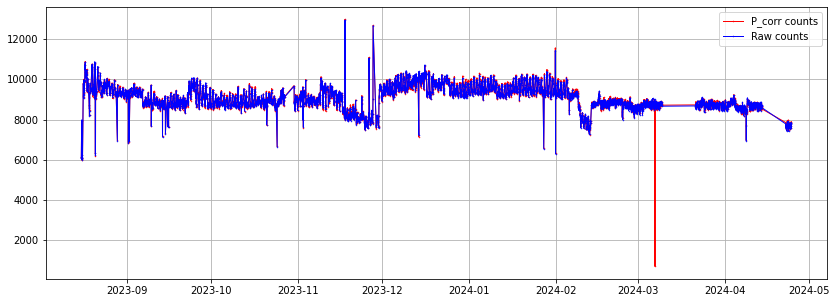

In [23]:
plt.rcParams["axes.grid"] = True
fig, (ax1) = plt.subplots(1,figsize=(14, 5))
#fig.suptitle('Counts')
#ax1.hist(df2_hourly['counts'], bins=100,histtype='step',label='Counts',color='blue')
ax1.plot(merged_df1["Icorr"],
marker='.', markersize=1, linestyle='-', linewidth=1, color='red', label='P_corr counts')
ax1.plot(merged_df1["counts"],
marker='.', markersize=1, linestyle='-', linewidth=1, color='blue', label='Raw counts')
#ax1.set_title('4 Paddle Counts')
#ax1.set_xlim([pd.Timestamp('2020-11-03'), pd.Timestamp('2021-04-20')])
ax1.legend();

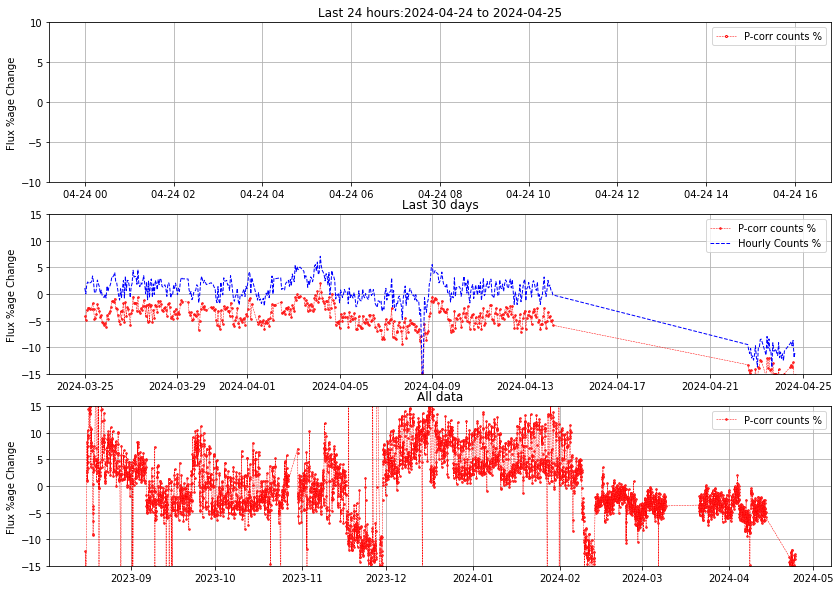

In [24]:
#title1 = now.year()
plt.rcParams["axes.grid"] = True
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3)
axs = gs.subplots(sharex=False, sharey=False)
#fig.suptitle('Flux %age Change (Muon001 Detector)')
#axs[0].set_title("Last 24 hours (yesterday:now)")
axs[0].set_title('Last 24 hours:'+str(yesterday)+' to ' +str(now))
axs[0].plot(merged_df1.loc[yesterday:now, 'Icorr_m_avg'],
markerfacecolor='white',markeredgecolor="red", marker='.', markersize=4, linestyle='--', linewidth=0.5, color='red', label='P-corr counts %')

axs[1].set_title("Last 30 days")
axs[1].plot(merged_df1.loc[lastmonth:now, 'Icorr_m_avg'],
markerfacecolor='white',markeredgecolor="red", marker='.', markersize=3, linestyle='--', linewidth=0.5, color='red', label='P-corr counts %')
axs[1].plot(merged_df_31days['counts_pct'],
linestyle='--', linewidth=1, color='blue', label='Hourly Counts %')

axs[2].set_title("All data")
axs[2].plot(merged_df1["Icorr_m_avg"],
markerfacecolor='white',markeredgecolor="red", marker='.', markersize=3, linestyle='--', linewidth=0.5, color='red', label='P-corr counts %')
#axs[2].plot(merged_df1["counts_m_avg"],
#markerfacecolor='white',markeredgecolor="blue", marker='o', markersize=3, linestyle='', linewidth=0.5, color='blue', label='P-corr counts %')



#axs[2].plot(df1_hourly["Ch23_m_avg"],
#marker='.', markersize=1, linestyle='-', linewidth=1, color='black', label='Ch23_m_avg')

axs[0].set_ylabel('Flux %age Change')
axs[0].set_ylim([-10, 10])
axs[0].legend();
axs[1].set_ylabel('Flux %age Change')
axs[1].set_ylim([-15, 15])
axs[1].legend();
axs[2].set_ylabel('Flux %age Change')
axs[2].set_ylim([-15, 15])
axs[2].legend();
# Hide x labels and tick labels for all but bottom plot.
#for ax in axs:
 #   ax.label_outer()
plt.savefig('/home/cosmic/onlineMon/images/markV_pct_Ch_Pcorr.png')

In [25]:
dayBeforeYesterday

datetime.date(2024, 4, 23)

In [26]:
twoDaysBefore


datetime.date(2024, 4, 22)

In [27]:
threeDaysBefore

datetime.date(2024, 4, 21)